# Backtesting Simple Cross Exchange Arb (day-level granularity)
## Source Data

In [19]:
# %load grab_data.py
# Modules
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib as plt
from datetime import datetime
import json
from bs4 import BeautifulSoup
import requests
%matplotlib inline

# Parameters
fsym    = "ETH"
tsym    = "USD"
url     = "https://www.cryptocompare.com/api/data/coinsnapshot/?fsym=" + \
          fsym + "&tsym=" + tsym
begin   = "2018-01-01"
end     = "2018-03-13"
dir_out = "../../data/in/"

# Function Defs
def fetchCryptoOHLC_byExchange(fsym, tsym, exchange):
    # a function fetches a crypto OHLC price-series for fsym/tsym and stores
    # it in a pandas DataFrame; uses specific Exchange as provided
    # src: https://www.cryptocompare.com/api/

    cols = ['date', 'timestamp', 'open', 'high', 'low', 'close']
    lst = ['time', 'open', 'high', 'low', 'close']

    timestamp_today = datetime.today().timestamp()
    curr_timestamp = timestamp_today

    for j in range(2):
        df = pd.DataFrame(columns=cols)
        url = "https://min-api.cryptocompare.com/data/histoday?fsym=" + fsym + \
              "&tsym=" + tsym + "&toTs=" + str(int(curr_timestamp)) + \
              "&limit=2000" + "&e=" + exchange
        response = requests.get(url)
        soup = BeautifulSoup(response.content, "html.parser")
        dic = json.loads(soup.prettify())

        for i in range(1, 2001):
            tmp = []
            for e in enumerate(lst):
                x = e[0]
                y = dic['Data'][i][e[1]]
                if (x == 0):
                    # timestamp-to-date
                    td = datetime.fromtimestamp(int(y)).strftime('%Y-%m-%d')
                    tmp.append(td)  # (str(timestamp2date(y)))
                tmp.append(y)
            if (np.sum(tmp[-4::]) > 0):
                df.loc[len(df)] = np.array(tmp)
        df.index = pd.to_datetime(df.date)
        df.drop('date', axis=1, inplace=True)
        curr_timestamp = int(df.iloc[0][0])

        if (j == 0):
            df0 = df.copy()
        else:
            data = pd.concat([df, df0], axis=0)

    return data.astype(np.float64)

# Grab Market Names
url = "https://min-api.cryptocompare.com/data/top/exchanges/full?fsym=" + \
       fsym + "&tsym=" + tsym
response = requests.get(url)
soup = BeautifulSoup(response.content, "html.parser")
dic = json.loads(soup.prettify())

# Process Names
vol = []
d = dic['Data']['Exchanges']  # a list
for i in range(len(d)):
    vol.append([d[i]['MARKET'], round(float(d[i]['VOLUME24HOUR']), 2)])

# sort a list of sublists according to 2nd item in a sublist
vol = sorted(vol, key=lambda x: -x[1])

# Grab Closing Prices
markets = [e[0] for e in vol][0:10]
if ('cp' in globals()) or ('cp' in locals()): del cp
for market in markets:
    df = fetchCryptoOHLC_byExchange(fsym, tsym, market)
    ts = df[(df.index > begin) & (df.index <= end)]["close"]
    ts.name = market
    if ('cp' in globals()) or ('cp' in locals()):
        cp = pd.concat([cp, ts], axis=1, ignore_index=False)
    else:
        cp = pd.DataFrame(ts)

# Save Data
cp.to_csv(dir_out + "cryptocompare_close.csv")

## Estimate Spread Distributions (mean, sd)
Compute the mean and standard deviation of spread between exchanges over windowed-time. Note that index $i$, $j$ in the spread matrices pertain to exchange$_i$ - exchange$_j$. Note that I $\textbf{do not}$ compute the same rate spread twice, e.g. Bitfini

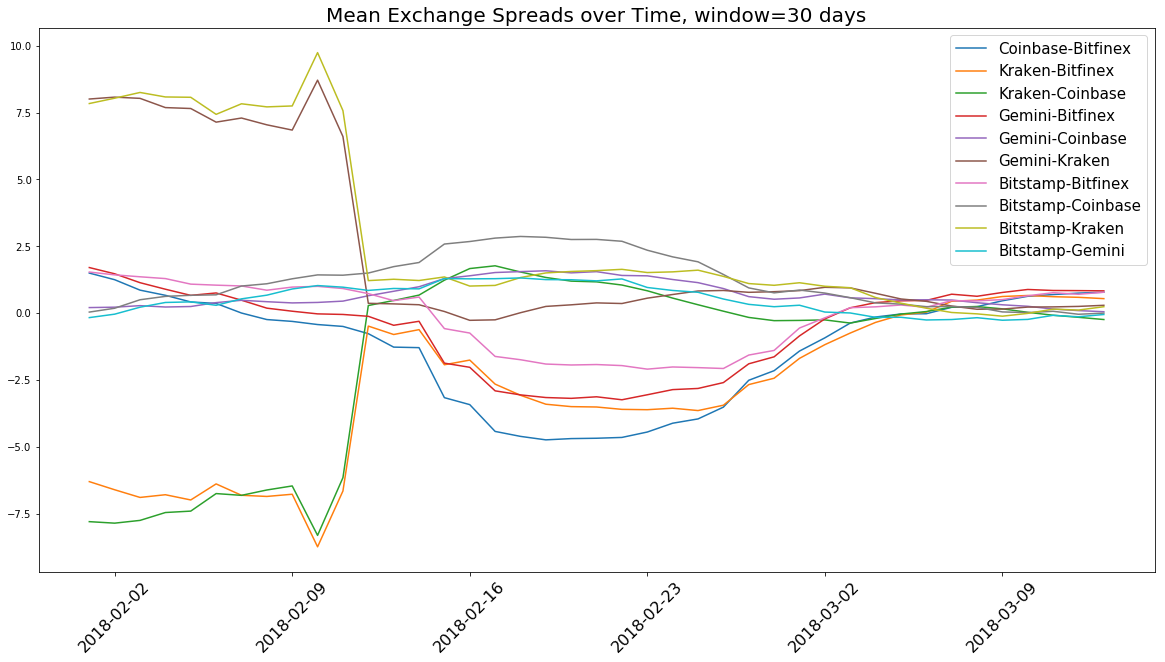

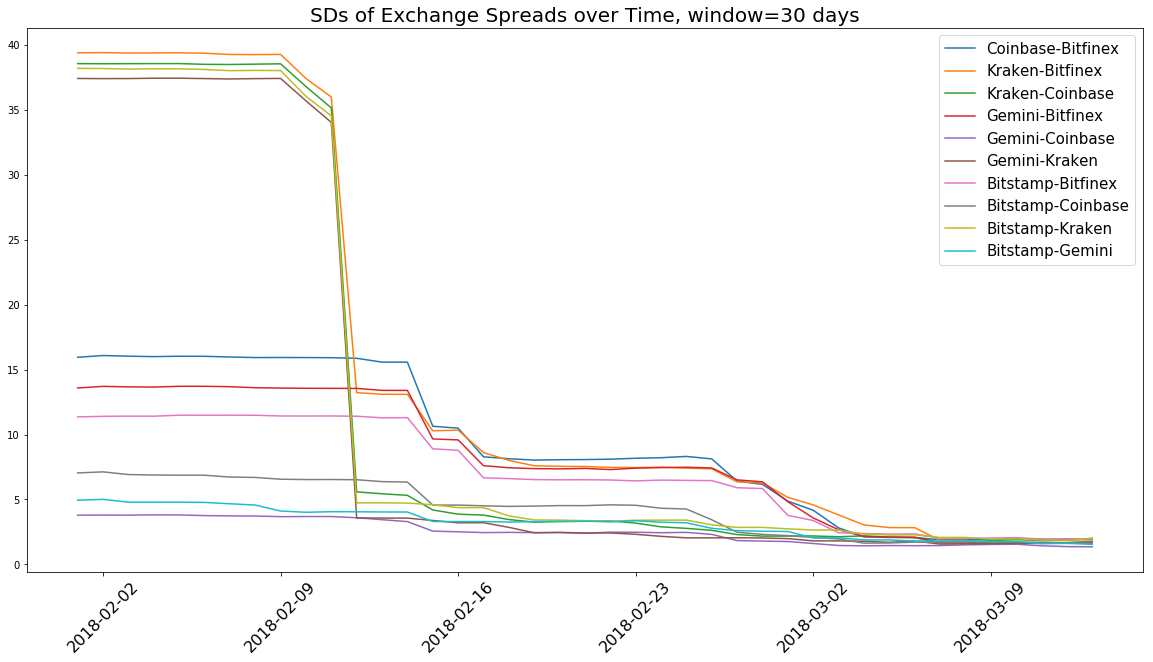

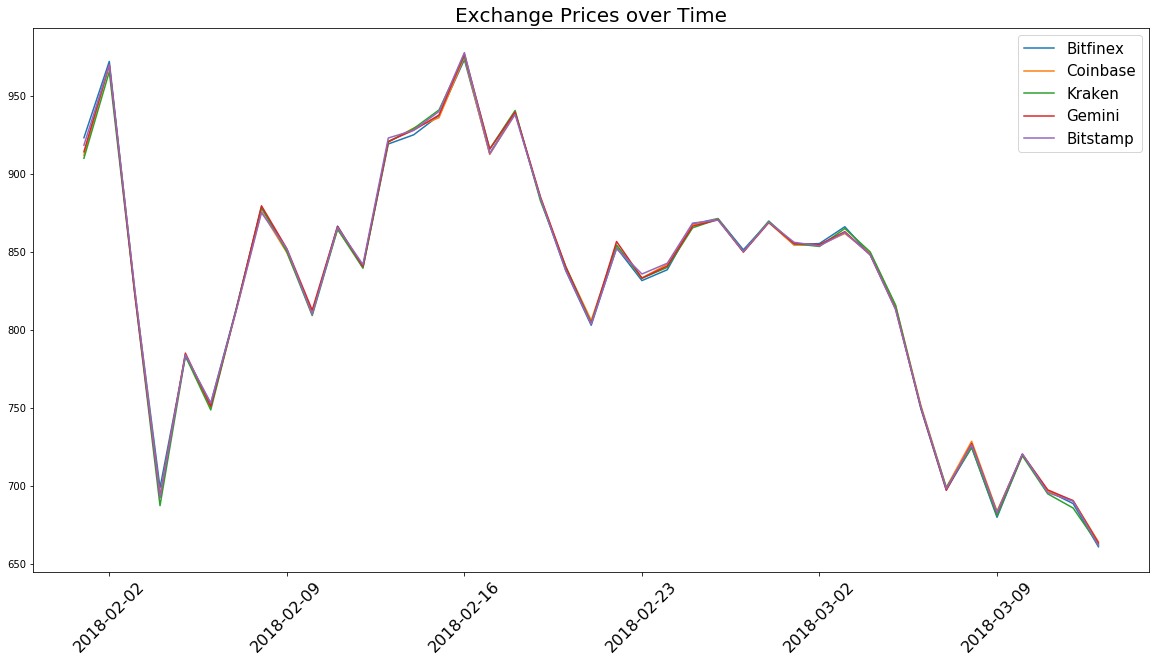

In [20]:
# %load est_sprd_dist.py
# Modules
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import datetime as dt
np.set_printoptions(suppress=True) # turn off sci notation

# Params
window = 30  # num days to look over for each dist realization
dir_in = "../../data/in/"

# Read Data
dat = pd.read_csv(dir_in + "cryptocompare_close.csv")

# Find Mean, SD for each Window and each Exchange Pair
# Size = (5 exchanges x 5 exchanges) x ~30 dates
df = dat.loc[:, dat.columns != 'date']  # no dates
exchanges = list(dat.columns[1:dat.shape[1]])
sprd_bin = np.zeros((len(exchanges), len(exchanges),
                     dat.shape[0]))
jexchanges = np.array(list(range(0, len(exchanges))))
for jexch in range(len(exchanges)):
    exchange = exchanges[jexch]
    diff = np.array(df.iloc[:, np.repeat(jexch, len(exchanges)-1)]) - \
           np.array(df.loc[:, df.columns != exchange])
    sprd_bin[jexch, jexchanges[jexchanges!=jexch]] = np.transpose(diff)

sprd_mean = np.zeros((len(exchanges), len(exchanges),
                      (dat.shape[0] - window)))
sprd_sd = np.zeros((len(exchanges), len(exchanges),
                      (dat.shape[0] - window)))
for jt in range(window, (dat.shape[0])):
    sub = sprd_bin[:, :, (jt-window):jt]
    sprd_mean[:, :, jt-window] = np.mean(sub, axis=2)
    sprd_sd[:, :, jt-window] = np.std(sub, axis=2)

# Plot Means and SDs over time
i = 0
while i < dat.shape[0]:
    dl = [int(x) for x in (dat.iloc[i, 0]).split('-')]
    dat.iloc[i, 0] = dt.datetime(dl[0], dl[1], dl[2])
    i += 1
x = list(dat.iloc[:, 0])
dates = x[window:len(x)]

plt.figure(figsize=(20, 10))
for x in range(1, len(exchanges)):
    for y in range(x):
        plt.plot(dates, sprd_mean[x, y, :], label=
        exchanges[x] + "-" + exchanges[y])

plt.xticks(size=16, rotation=45)
plt.legend(prop={'size': 15})
plt.title("Mean Exchange Spreads over Time, window="+str(window)+" days",
          size=20)
plt.show()

plt.figure(figsize=(20, 10))
for x in range(1, len(exchanges)):
    for y in range(x):
        plt.plot(dates, sprd_sd[x, y, :], label=
        exchanges[x] + "-" + exchanges[y])

plt.xticks(size=16, rotation=45)
plt.legend(prop={'size': 15})
plt.title("SDs of Exchange Spreads over Time, window="+str(window)+" days",
          size=20)
plt.show()

# Plot simple Time Series of each Exchange
plt.figure(figsize=(20, 10))
for x in range(0, len(exchanges)):
    plt.plot(dates, dat.iloc[window:dat.shape[0], x+1], label=
        exchanges[x])

plt.xticks(size=16, rotation=45)
plt.legend(prop={'size': 15})
plt.title("Exchange Prices over Time", size=20)
plt.show();

## Backtesting
Trading is assumed to take place daily, e.g. make new cohort of trades daily with new data. The $\textit{n}$ strongeset deviations from the their mean spread as measured by number of standard deviations that are traded on can be changed by using the varialbe $\texttt{topmax}$. We choose the strongest deviation as the positive deviations (there are mirrored negative deviations). The return would be the same either way. Unless there is a compelling reason to change this it doesn't matter. 

In [41]:
# %load backtest.py
# Modules
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import datetime as dt
np.set_printoptions(suppress=True) # turn off sci notation

# Parameters
# (defined above) window = 30  # num days to look over for each dist realization
dir_in     = "../../data/in/"
acct_start = 1000  # dollars per exchange account
topmax     = 1 # the strongest n deviations to trade
cush       = 0.15  # cushion to leave in acct bals

# Function Defs
def comp_sprds(prices):
    sprd = np.zeros((len(exchanges), len(exchanges)))
    for jexch in range(len(exchanges)):
        exchange = exchanges[jexch]
        diff = np.array(prices[np.repeat(jexch, len(exchanges)-1)]) - \
               np.array(prices[df.columns != exchange])
        sprd[jexch, jexchanges[jexchanges!=jexch]] = np.transpose(diff)
    return(sprd)

# Backtest
exchanges = list(dat.columns[1:dat.shape[1]])
jexchanges = np.array(list(range(0, len(exchanges))))
acct_bals = np.zeros((df.shape[0]-window, df.shape[1]))  # dollars in exchanges (shape: time x num exchanges)
acct_bals[0, :] = acct_start
acct_poss = np.zeros((df.shape[0]-window, df.shape[1]))  # positions in each exchange (units)

for jt in range(window, dat.shape[0]):
    # Compute profit from last period. 
    if jt > window:
        price_chng = df.iloc[jt, :] - df.iloc[jt-1, :]
        acct_bals[jt-window, :] = acct_bals[jt-window-1, :] + acct_poss[jt-window-1, :] * price_chng
        
    # Find topmax number of strongest deviations
    max_idx_list = []
    max_sd_devs = []
    sprds = comp_sprds(dat.iloc[jt,1:len(exchanges)+1])
    trail_means = sprd_mean[:, :, jt-window]
    trail_sd = sprd_sd[:, :, jt-window]
    numSD_devs = (sprds - trail_means) / (trail_sd + np.identity(len(exchanges)))
    for jmax in range(0, topmax):  # choose highest deviations
        idx = np.where(numSD_devs == numSD_devs.max())
        max_idx_list.append(idx)
        max_sd_devs.append(numSD_devs[idx])
        numSD_devs[idx] = 0
        numSD_devs[:, idx[1]] = 0
        numSD_devs[idx[0], :] = 0
    
    # Compute number of dollars and position in trades
    for jmax in range(0, topmax):
        exch1 = max_idx_list[jmax][0]
        exch2 = max_idx_list[jmax][1]
        dllrs = np.min((acct_bals[jt-window, exch1], acct_bals[jt-window, exch2])) \
                * (1-cush)  # trade with min(acct1, acct2)
        acct_poss[jt-window, exch1] = - float(df.iloc[jt, exch1] / dllrs)  # short the exchange above the mean,
        acct_poss[jt-window, exch2] = float(df.iloc[jt, exch2] / dllrs)  # long the exchange below the mean
        

## Plot Account Balances

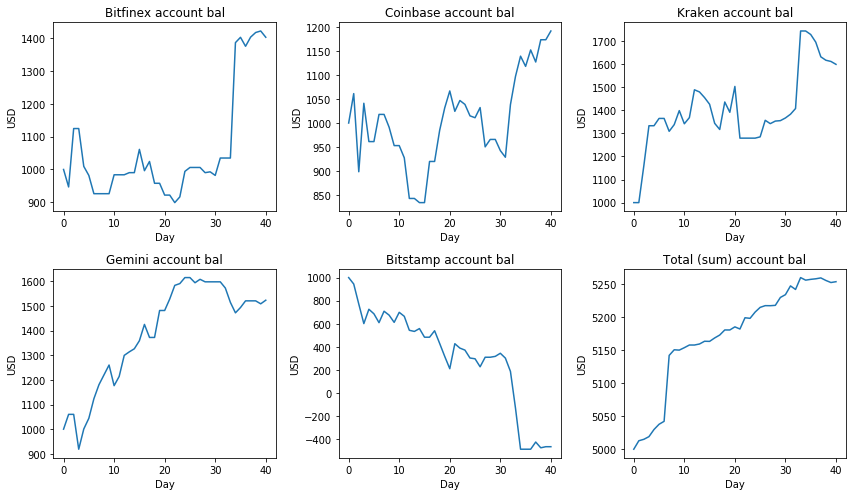

In [42]:
plt.figure(figsize=(12,7))
 
for j in range(len(exchanges)):
    plt.subplot(2,3,j+1)
    plt.plot(acct_bals[:, j])
    plt.title(exchanges[j] + " account bal")
    plt.xlabel("Day"); plt.ylabel("USD")

plt.subplot(2,3,6)
plt.plot(np.sum(acct_bals, axis=1))
plt.title("Total (sum) account bal")
plt.xlabel("Day"); plt.ylabel("USD")
    
plt.tight_layout()

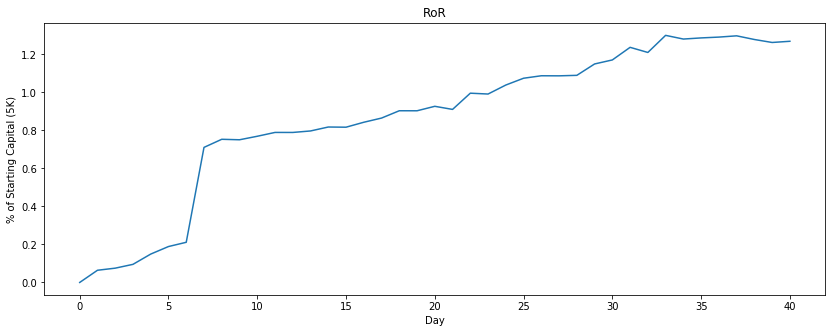

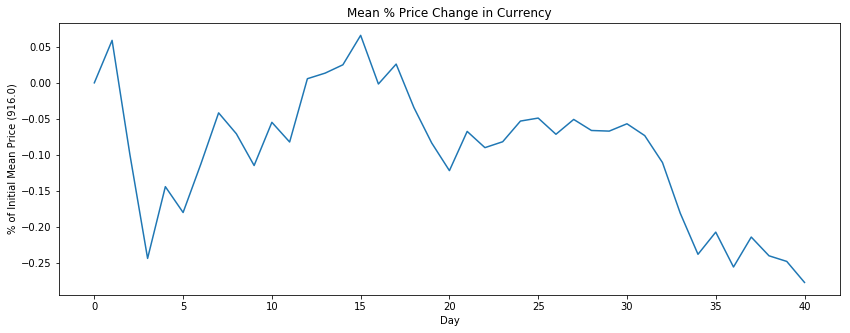

In [66]:
plt.figure(figsize=(14,5))
plt.plot((np.sum(acct_bals, axis=1) - acct_start*5) / acct_start*5)
plt.title("RoR")
plt.xlabel("Day"); plt.ylabel("% of Starting Capital (5K)")
plt.show()

plt.figure(figsize=(14,5))
plt.plot([x for x in range(0, df.shape[0]-window)], 
         (np.mean(df.iloc[window:df.shape[0], :], axis=1) - np.mean(df.iloc[window, :])) /
         np.mean(df.iloc[window,:]))
plt.title("Mean % Price Change in Currency")
strtpr = np.round(np.mean(df.iloc[window, :]))
plt.xlabel("Day"); plt.ylabel("% of Initial Mean Price " + "(" + str(strtpr) + ")")
plt.show()

The return isn't totalling convincing but in the time period I chose it seems to have done well in a down market, +1.2% RoR when ETH declined 0.2% overall. I'll test it during other times, with other currencies than ETH etc. There is also the issue of the bitsamp account, which went into the negative values. I'll have to put into place some guards against that /  figure out why it happened.

The sharpe ratio of this trading scheme is computed as:

In [53]:
tot = np.sum(acct_bals, axis=1)
ror = (tot[len(tot)-1] - acct_start*5) / acct_start*5
sharpe = ror / np.std(tot)
print("Sharpe Ratio: " + str(sharpe))

Sharpe Ratio: 0.016341797024536128
